In [6]:
from qdisk.model import Keplerian_velocity
from qdisk.classes import FitsImage
import eDiskplot as eplot
from qdisk.utils import is_within
from qdisk.plot import ChannelMap, Map
import analysis_utils as au
from eDisk_source_dict import source_dict
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel, convolve_fft
from analysis_utils import FWHM_to_sigma
from mcmc_tools import log_prior, emcee_run_wrapper, plot_corner, plot_walker
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patheffects as pe
from astropy.visualization import ImageNormalize
from qdisk.product import calculate_radial_profile
%matplotlib widget
%load_ext autoreload
%autoreload 2

source = "L1489IRS"
config = "SBLB"
line = "C18O"
robust = 1.0
center_coord = source_dict[source]["radec"]
PA = source_dict[source]["PA"]
incl = source_dict[source]["incl"]
distance = source_dict[source]["distance"]
vsys = source_dict[source]["v_sys"]

mom0name = au.VADPpath + au.get_image_basename(source, config, line, robust=robust).replace(".fits", "_M0.fits")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
rmax = 8

linelist = ["12CO", "13CO", "C18O", "SO"]
robust = {"12CO": 0.5, "13CO": 0.5, "C18O": 1.0, "SO": 1.0}
wedge = [30, 60, 90]

for w in wedge:
    for line in linelist:
        mom0name = au.VADPpath + au.get_image_basename(source, config, line, robust=robust[line]).replace(".fits", "_M0.fits")
        calculate_radial_profile(mom0name, PA=PA, incl=incl, center_coord=center_coord, rmax=rmax, wedge_angle=w, save=True, savefileheader="r [arcsec] \t I [mJy/beam km/s] \t dI [mJy/beam km/s]")

Loading data...
Calculating radial profile...
Loading data...
Calculating radial profile...
Loading data...
Calculating radial profile...
Loading data...
Calculating radial profile...
Loading data...
Calculating radial profile...
Loading data...
Calculating radial profile...
Loading data...
Calculating radial profile...
Loading data...
Calculating radial profile...
Loading data...
Calculating radial profile...
Loading data...
Calculating radial profile...
Loading data...
Calculating radial profile...
Loading data...
Calculating radial profile...


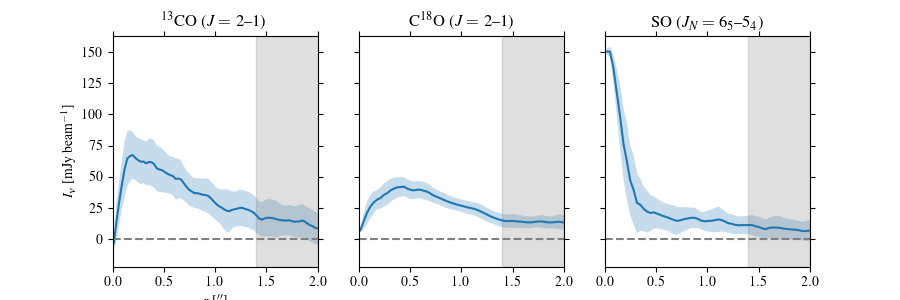

In [29]:
linelist = ["13CO", "C18O", "SO"]

fig, axes = plt.subplots(1, len(linelist), sharex=True, sharey=True, figsize=(9, 3))

wedge = 90

for i, line in enumerate(linelist):

    ax = axes[i]

    radprofname = au.VADPpath + au.get_image_basename(
        source, config, line, robust=robust[line]
    ).replace(".fits", "_M0_radialProfileWedge{}deg.txt".format(wedge))
    r, I, dI = np.loadtxt(radprofname, unpack=True)

    ax.plot(r, I, color="tab:blue")
    ax.fill_between(r, I-dI, I+dI, color="tab:blue", alpha=0.25, edgecolor=None)

    ax.axhline(y=0.0, color="grey", ls="dashed")
    ax.axvspan(xmin=1.4, xmax=2.0, color="grey", alpha=0.25, edgecolor=None)

    ax.set_title(eplot.linelabel[line])

    if i == 0:
        ax.set(xlim=(0.0, 2), xlabel="$r$ [$^{\prime\prime}$]", ylabel=r"$I_{\nu}$ [mJy beam$^{-1}$]")

    fig.savefig(au.figurepath + "13CO_C18O_SO_radialprofile_gallery.pdf", bbox_inches="tight", pad_inches=0.01)


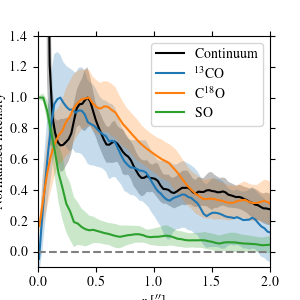

In [42]:
# comparison
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# continuum
radprofname = au.VADPpath + au.get_image_basename(
    source, config, "continuum", robust=1.0
).replace(".fits", "_radialProfileWedge{}deg.txt".format(wedge))
r, I, dI = np.loadtxt(radprofname, unpack=True)

# normalize by ring peak
dI /= np.nanmax(I[r > 0.3])
I /= np.nanmax(I[r > 0.3])

ax.plot(r, I, color="black", label="Continuum")
ax.fill_between(r, I-dI, I+dI, color="black", alpha=0.25, edgecolor=None)

for i, line in enumerate(linelist):

    radprofname = au.VADPpath + au.get_image_basename(
        source, config, line, robust=robust[line]
    ).replace(".fits", "_M0_radialProfileWedge{}deg.txt".format(wedge))
    r, I, dI = np.loadtxt(radprofname, unpack=True)

    dI /= np.nanmax(I)
    I /= np.nanmax(I)

    ax.plot(r, I, label=eplot.linelabel_noqn[line])
    ax.fill_between(r, I - dI, I + dI, alpha=0.25, edgecolor=None)

ax.set(xlim=(0.0, 2.0), ylim=(-0.1, 1.4), xlabel="$r$ [$^{\prime\prime}$]", ylabel=r"Normalized intensity")
ax.axhline(y=0.0, color="grey", ls="dashed")
ax.legend()

fig.savefig("13CO_C18O_SO_radialprofile_comparison.pdf", bbox_inches="tight", pad_inches=0.01)
